# Optimizations

Here we are trying to understand some optimizations we can do to our models.<br/>
For the use case let's use pet breeds dataset.

In [6]:
from fastai2.vision.all import *

In [7]:
im_path = untar_data(URLs.PETS)

In [8]:
(im_path/"images").ls()

(#7393) [Path('/storage/data/oxford-iiit-pet/images/Ragdoll_197.jpg'),Path('/storage/data/oxford-iiit-pet/images/newfoundland_36.jpg'),Path('/storage/data/oxford-iiit-pet/images/boxer_107.jpg'),Path('/storage/data/oxford-iiit-pet/images/scottish_terrier_5.jpg'),Path('/storage/data/oxford-iiit-pet/images/yorkshire_terrier_136.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_21.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_188.jpg'),Path('/storage/data/oxford-iiit-pet/images/chihuahua_139.jpg'),Path('/storage/data/oxford-iiit-pet/images/basset_hound_44.jpg'),Path('/storage/data/oxford-iiit-pet/images/Russian_Blue_135.jpg')...]

In [9]:
def get_pet_category(p):
    return re.sub('_.*', '', p.name)

get_pet_category((im_path/"images").ls()[0])

'Ragdoll'

In [10]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(0.3),
    get_y=get_pet_category,
    item_tfms=Resize(224)
)

In [11]:
dls = db.dataloaders(im_path/"images")

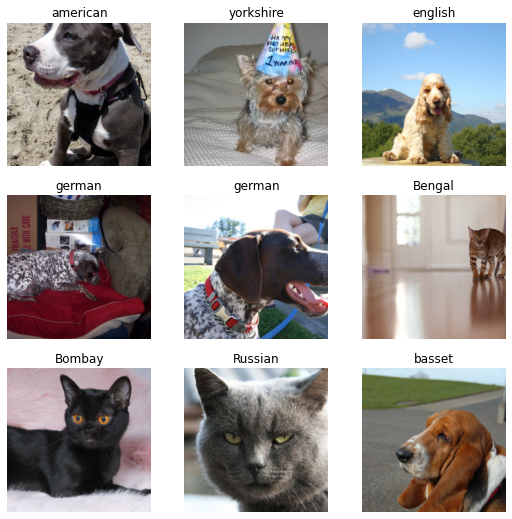

In [12]:
dls.show_batch()

## Let's train without any optimizations

In [13]:
learn1 = cnn_learner(dls, resnet34, metrics=error_rate)

In [14]:
learn1.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.484421,5.217881,0.428507,00:18


epoch,train_loss,valid_loss,error_rate,time
0,4.160625,19.663805,0.850699,00:19
1,2.096231,1.037945,0.314840,00:18


**See. The error rate is becoming worst.**

That's because we choose a very high learning rate. And it'll make things worst.
It'll do steep jumps.

So, we might not be able to get a really good point.

## Learning Rate Finder.

This is a tool where we can find a learning rate for our dataset.

In [15]:
learn2 = cnn_learner(dls, resnet34, metrics=error_rate)

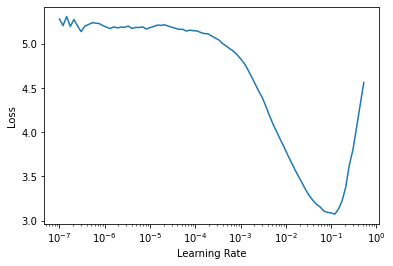

In [16]:
lr_info = learn2.lr_find()

Here, it first starts with very small learning rates and apply for each minibatches. Then it captures the loss.

Likewise it'll increase the learning rate and plot the loss.
Then it'll stop when we make the loss worst.

In [17]:
print(f'Bottom/10: {lr_info[0]:.2e}')
print(f'Steep: {lr_info[1]:.2e}')

Bottom/10: 1.20e-02
Steep: 3.63e-03


So, the best one would be something in middle.

In [18]:
import math

In [19]:
## We can take the optimial lr as the middle of the both lr.find() values in the log scale
log_mid = (math.log10(lr_info[0]) + math.log10(lr_info[1]))/2
opt_lr = 10 ** log_mid
opt_lr

0.006606934523426871

In [20]:
learn2.fine_tune(2, base_lr=opt_lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.085329,0.337669,0.102391,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.710879,0.718103,0.199369,00:18
1,0.377816,0.246148,0.082995,00:18


**See. It now give us much better error_rate with lessor epochs.**

But the training time is the same.

## FP16

This is trick in GPU to make it a bit worst. But it makes the model faster to train. 
Let's check.

In [21]:
from fastai2.callback.fp16 import *

In [24]:
learn3 = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()

In [25]:
learn3.fine_tune(2, base_lr=opt_lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.141544,0.299870,0.096978,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.738572,0.736430,0.199369,00:19
1,0.364398,0.260431,0.079387,00:19


With our a bunch of GPUs in Paperspace, this doesn't make any difference.

May be those GPUs are old and does not have fp16 support.